<a href="https://colab.research.google.com/github/IonPanteleiciuc/PFP/blob/main/SkinLesion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas==1.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
print(pd.__version__)

import os
from PIL import Image
import numpy as np
import time
import random as rd
import tqdm

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import os
import time
import shutil

import pickleshare

from google.colab import files

1.5.2


### **Data importation & visualization**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_arr = pd.read_pickle('/content/drive/MyDrive/SkinLesion/data/data_arr.csv')

In [5]:
data_arr.head()

,target,arr
image_name,,
ISIC_2637011,0,"[[[[192 142 141], [183 133 132], [154 104 107]..."
ISIC_0015719,0,"[[[[158 98 70], [156 96 68], [158 98 74]..."
ISIC_0052212,0,"[[[[198 133 153], [197 132 152], [194 129 149]..."
ISIC_0068279,0,"[[[[113 59 59], [117 63 63], [113 57 58]..."
ISIC_0074268,0,"[[[[167 118 104], [170 121 107], [173 124 109]..."


In [6]:
X_ids = data_arr.index.values

label_0 = data_arr[data_arr["target"] == 0].index.values
label_1 = data_arr[data_arr["target"] == 1].index.values

nb_label_0 = data_arr[data_arr["target"] == 0].shape[0]
nb_label_1 = data_arr[data_arr["target"] == 1].shape[0]

total_labeled_data = nb_label_0 + nb_label_1

In [7]:
print(f"Total data: {total_labeled_data}\n")

print(f"We have {nb_label_0} ({np.round(nb_label_0/total_labeled_data * 100, 2) } %) benign labeled samples")

print(f"We have {nb_label_1} ({np.round(nb_label_1/total_labeled_data * 100, 2)} %) malignant labeled samples")

Total data: 46558

We have 32542 (69.9 %) benign labeled samples
We have 14016 (30.1 %) malignant labeled samples


In [8]:
def getArr(id):
    return data_arr.loc[f"{id}"]["arr"][0]

In [9]:
def getY(id):
  return data_arr.loc[f"{id}"]["target"]

In [10]:
def show(id):
    return Image.fromarray(getArr(id))

In [11]:
getArr("ISIC_9955163")

array([[[115,  90,  70],
        [121,  96,  76],
        [128, 100,  79],
        ...,
        [108,  74,  49],
        [108,  73,  45],
        [107,  72,  44]],

       [[117,  92,  72],
        [124,  97,  78],
        [130, 102,  81],
        ...,
        [106,  72,  47],
        [106,  71,  43],
        [105,  70,  42]],

       [[120,  93,  74],
        [126,  99,  80],
        [131, 103,  82],
        ...,
        [105,  69,  45],
        [105,  68,  41],
        [104,  67,  40]],

       ...,

       [[ 81,  54,  37],
        [ 97,  70,  53],
        [115,  86,  68],
        ...,
        [110,  79,  61],
        [111,  78,  61],
        [112,  76,  62]],

       [[ 87,  59,  45],
        [101,  74,  57],
        [116,  87,  71],
        ...,
        [108,  80,  68],
        [108,  78,  67],
        [110,  78,  67]],

       [[ 53,  25,  13],
        [ 62,  34,  20],
        [ 74,  45,  31],
        ...,
        [ 43,  15,   3],
        [ 44,  14,   4],
        [ 45,  12,   3]]

In [ ]:
getY("ISIC_9955163")

In [ ]:
show("ISIC_9955163")

### **Process data**

In [12]:
X_ids

array(['ISIC_2637011', 'ISIC_0015719', 'ISIC_0052212', ...,
       'ISIC_9053910_zoom_1.1', 'ISIC_5258657_mh_r180_zoom_1.1',
       'ISIC_3065032_mh_r90_zoom_1.2'], dtype=object)

In [11]:
def splitData(train_percentage, validation_percentage, test_percentage):

  if train_percentage + validation_percentage + test_percentage != 1:
    return False

  ids = X_ids.copy()

  count_data = len(ids)

  train_len = np.round(count_data * train_percentage).astype("int")
  validation_len = np.round(count_data * validation_percentage).astype("int")
  test_len = np.round(count_data * test_percentage).astype("int")

  rd.shuffle(ids)

  train_paths = ids[:train_len]
  validation_paths = ids[train_len:train_len+validation_len]
  test_paths = ids[train_len+validation_len:]

  return train_paths, validation_paths, test_paths

In [12]:
def getLabels(ids):
  labels = []
  for id in ids:
    labels.append(getY(id))
  return np.resize(np.array((labels)), (len(labels), 1))

In [13]:
def getArrays(ids):
    output = []
    for id in ids:
        output.append(getArr(id))
    return np.array(output)

In [14]:
def load_data(train_portion, val_portion, test_portion):
  train_paths, validation_paths, test_paths = splitData(train_portion, val_portion, test_portion)
  
  train_images = getArrays(train_paths)
  train_labels = getLabels(train_paths)

  validation_images = getArrays(validation_paths)
  validation_labels = getLabels(validation_paths)

  test_images = getArrays(test_paths)
  test_labels = getLabels(test_paths)

  return (train_images, train_labels), (validation_images, validation_labels), (test_images, test_labels)

# **AlexNet Model**

In [ ]:
# (train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
(train_images, train_labels), (validation_images, validation_labels), (test_images, test_labels) = load_data(0.8, 0.1, 0.1)

In [1]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

NameError: ignored

In [17]:
CLASS_NAMES= ["benign", "malignant"]

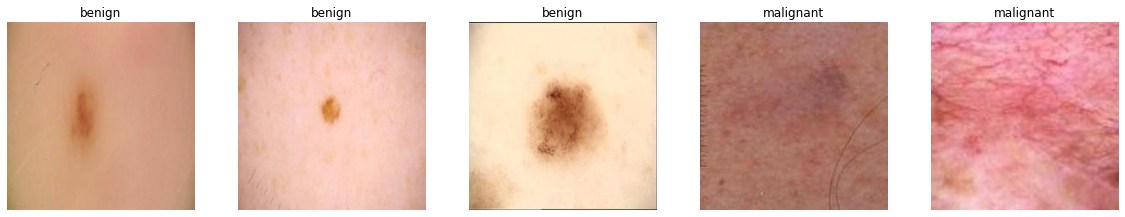

In [18]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [19]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    return image, label

In [20]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 37246
Test data size: 4656
Validation data size: 4656


In [21]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=64, drop_remainder=True))

test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=64, drop_remainder=True))
                  
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=64, drop_remainder=True))

In [22]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Flatten(),

    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
root_logdir = os.path.join("/content/drive/MyDrive/SkinLesion/", "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [24]:
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.fit(train_ds,
          epochs=20,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/20


In [ ]:
model.evaluate(test_ds)

In [ ]:
model.save_weights("/content/drive/MyDrive/SkinLesion/checkpoints/AlexNet_w_v2")

In [ ]:
model.save("/content/drive/MyDrive/SkinLesion/saved_model/AlexNet_v2")

In [ ]:
# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))